In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as pl
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import statsmodels.api as sm
import pickle


# Step 1: Setup
trial_pp_dir = "trial_pp"
trial_itt_dir = "trial_itt"
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)


In [3]:
# Step 2: Data Preparation
df = pd.read_csv("data/data_censored.csv")
print(df.head())
print(df.describe())

# Fixing ID issue: Ensure IDs are not just 1 and 2
df["id"] = df.groupby("id").ngroup() + 1

# Per-protocol
trial_pp = {
    "data": df,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# ITT
trial_itt = {
    "data": df,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

print("Trial Sequence Object")
print("Estimand: Per-Protocol")
print(f"Data: \n##  - N: {df.shape[0]} observations from {df['id'].nunique()} patients")
print(df.head(10).to_string(index=False))

print("Estimand: Intention-to-Treat")
print(f"Data: \n##  - N: {df.shape[0]} observations from {df['id'].nunique()} patients")
print(df.head(10).to_string(index=False))



   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      1.000000    0.000000    0.000000    0.0000

In [ ]:
# Step 3: Weight Models and Censoring
def fit_logit_model(formula, df, save_path):
    """Fits a logistic regression model, saves it, and returns the predicted probabilities."""
    model = sm.Logit.from_formula(formula, data=df).fit()
    model.save(save_path)
    return model.predict(df)

# Load existing processed data if available
pp_file = os.path.join(trial_pp_dir, "processed_data.csv")
itt_file = os.path.join(trial_itt_dir, "processed_data.csv")

if os.path.exists(pp_file):
    df_existing_pp = pd.read_csv(pp_file)
else:
    df_existing_pp = None

if os.path.exists(itt_file):
    df_existing_itt = pd.read_csv(itt_file)
else:
    df_existing_itt = None

# Compute Treatment Switching Weights
df["switch_numerator"] = fit_logit_model("treatment ~ age", df, os.path.join(trial_pp_dir, "switch_numerator.pkl"))
df["switch_denominator"] = fit_logit_model("treatment ~ age + x1 + x3", df, os.path.join(trial_pp_dir, "switch_denominator.pkl"))
df["switch_weight"] = df["switch_numerator"] / df["switch_denominator"]

# Compute Censoring Weights (Per-Protocol)
df["censor_numerator_pp"] = fit_logit_model("censored ~ x2", df, os.path.join(trial_pp_dir, "censor_numerator.pkl"))
df["censor_denominator_pp"] = fit_logit_model("censored ~ x2 + x1", df, os.path.join(trial_pp_dir, "censor_denominator.pkl"))
df["censor_weight_pp"] = df["censor_numerator_pp"] / df["censor_denominator_pp"]

# Compute Censoring Weights (ITT)
df["censor_numerator_itt"] = fit_logit_model("censored ~ x2", df, os.path.join(trial_itt_dir, "censor_numerator.pkl"))
df["censor_denominator_itt"] = fit_logit_model("censored ~ x2 + x1", df, os.path.join(trial_itt_dir, "censor_denominator.pkl"))
df["censor_weight_itt"] = df["censor_numerator_itt"] / df["censor_denominator_itt"]

# If previous files exist, update only relevant columns instead of overwriting
if df_existing_pp is not None:
    df_existing_pp.update(df[["switch_weight", "censor_weight_pp"]])
    df_existing_pp.to_csv(pp_file, index=False)
else:
    df.to_csv(pp_file, index=False)

if df_existing_itt is not None:
    df_existing_itt.update(df[["censor_weight_itt"]])
    df_existing_itt.to_csv(itt_file, index=False)
else:
    df.to_csv(itt_file, index=False)

# Print summary
print("Censor and switch weights updated successfully.")
print(df[["switch_weight", "censor_weight_pp", "censor_weight_itt"]].head())


Optimization terminated successfully.
         Current function value: 0.662406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660234
         Iterations 5
Switch weights computed successfully.
   switch_numerator  switch_denominator  switch_weight
0          0.592014            0.636513       0.930088
1          0.581815            0.626528       0.928634
2          0.571545            0.549849       1.039459
3          0.561214            0.539206       1.040816
4          0.550830            0.595948       0.924292
Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
Censor weights compu

In [8]:
# step 4: Calculate Weights
# Function to load and display logistic regression model summaries
def show_weight_model(model_path):
    """Loads a saved logistic regression model and prints its summary."""
    with open(model_path, "rb") as file:
        model = pickle.load(file)
    print(model.summary())

# Display Per-Protocol Weight Models
print("\nWeight Models for Per-Protocol (PP) Censoring:")
show_weight_model(os.path.join(trial_pp_dir, "censor_numerator.pkl"))
show_weight_model(os.path.join(trial_pp_dir, "censor_denominator.pkl"))

print("\nWeight Models for Intention-to-Treat (ITT) Censoring:")
show_weight_model(os.path.join(trial_itt_dir, "censor_numerator.pkl"))
show_weight_model(os.path.join(trial_itt_dir, "censor_denominator.pkl"))

print("\nWeight Models for Treatment Switching:")
show_weight_model(os.path.join(trial_pp_dir, "switch_numerator.pkl"))
show_weight_model(os.path.join(trial_pp_dir, "switch_denominator.pkl"))



Weight Models for Per-Protocol (PP) Censoring:
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        21:55:48   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4481      0.141    -17.415      0.000      -2.724      -2.173
x2             0.4486      0.137      3.278      0.001       0.180       0.717
    

In [34]:
# Step 5: Specify Outcome Model (Per-Protocol)
outcome_model_pp = sm.GLM.from_formula(
    "outcome ~ treatment",  # Outcome modeled with treatment (no extra adjustment)
    data=df,
    family=sm.families.Binomial(),  # Assuming binary outcome (use Gaussian() for continuous)
    freq_weights=df["switch_weight"]  # Uses stabilized weights
).fit()

# Step 5: Specify Outcome Model (Intention-to-Treat with adjustment for x2)
outcome_model_itt = sm.GLM.from_formula(
    "outcome ~ treatment + x2",  # Adjusting for x2
    data=df,
    family=sm.families.Binomial(),
    freq_weights=df["censor_weight_itt"]  # Uses censoring weights
).fit()

# Print model summaries
print("\nOutcome Model (Per-Protocol):")
print(outcome_model_pp.summary())

print("\nOutcome Model (Intention-to-Treat, Adjusted for x2):")
print(outcome_model_itt.summary())



Outcome Model (Per-Protocol):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                   727.12
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57.189
Date:                Sun, 09 Mar 2025   Deviance:                       114.38
Time:                        22:03:09   Pearson chi2:                     729.
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002481
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8413

In [36]:
# Step 6: Expand Trials
def expand_trials(df, chunk_size=500):
    """Expands dataset into target trial sequences."""
    
    expanded_data = []
    
    for i, patient_id in enumerate(df["id"].unique()):
        patient_data = df[df["id"] == patient_id].copy()
        
        for trial_period in range(len(patient_data)):
            expanded_entry = patient_data.iloc[trial_period].copy()
            expanded_entry["trial_period"] = trial_period
            expanded_entry["followup_time"] = trial_period  # Assuming follow-up time aligns with trial_period
            expanded_entry["assigned_treatment"] = expanded_entry["treatment"]  # Assigned treatment stays the same
            
            expanded_data.append(expanded_entry)
        
        # Process in chunks (optional, useful for large datasets)
        if (i + 1) % chunk_size == 0:
            print(f"Processed {i + 1} patients...")

    return pd.DataFrame(expanded_data)

# Apply Expansion for PP & ITT
trial_pp_expanded = expand_trials(df, chunk_size=500)
trial_itt_expanded = expand_trials(df, chunk_size=500)

# Save expanded trials
trial_pp_expanded.to_csv(os.path.join(trial_pp_dir, "expanded_trials.csv"), index=False)
trial_itt_expanded.to_csv(os.path.join(trial_itt_dir, "expanded_trials.csv"), index=False)

# Display first 5 rows
print("\nExpanded Trial (PP):")
print(trial_pp_expanded.head())

print("\nExpanded Trial (ITT):")
print(trial_itt_expanded.head())



Expanded Trial (PP):
    id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
1  1.0     1.0        1.0  1.0  0.002200  0.0  0.734203  37.0  0.166667   
2  1.0     2.0        1.0  0.0 -0.481762  0.0  0.734203  38.0  0.250000   
3  1.0     3.0        1.0  0.0  0.007872  0.0  0.734203  39.0  0.333333   
4  1.0     4.0        1.0  1.0  0.216054  0.0  0.734203  40.0  0.416667   

   outcome  ...  switch_weight  censor_numerator_pp  censor_denominator_pp  \
0      0.0  ...       0.930088             0.126322               0.085615   
1      0.0  ...       0.928634             0.079651               0.051819   
2      0.0  ...       1.039459             0.065117               0.080719   
3      0.0  ...       1.040816             0.079837               0.099556   
4      0.0  ...       0.924292             0.086974               0.056993   

   censor_weight_pp  censor_numerator_itt  censor_denomina

In [37]:
# Step 7: Load or Sample Expanded Data
def load_expanded_data(df, seed=1234, p_control=0.5):
    """Loads expanded data and applies downsampling if needed."""
    np.random.seed(seed)
    
    # Keep all observations where outcome == 1
    df_case = df[df["outcome"] == 1]

    # Randomly sample p_control% of outcome == 0 cases
    df_control = df[df["outcome"] == 0].sample(frac=p_control, random_state=seed)

    # Combine and shuffle dataset
    df_sampled = pd.concat([df_case, df_control]).sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_sampled

# Apply Sampling to ITT Expanded Data
trial_itt_sampled = load_expanded_data(trial_itt_expanded, seed=1234, p_control=0.5)

# Save sampled data
trial_itt_sampled.to_csv(os.path.join(trial_itt_dir, "sampled_trials.csv"), index=False)

# Display first 5 rows
print("\nSampled ITT Data:")
print(trial_itt_sampled.head())



Sampled ITT Data:
     id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  78.0     1.0        0.0  1.0 -0.380892  0.0 -0.682909  43.0  0.666667   
1  85.0     6.0        1.0  1.0  0.454289  0.0 -0.001647  43.0  0.666667   
2  86.0    12.0        0.0  0.0 -1.025072  1.0 -1.293043  59.0  2.000000   
3  68.0     7.0        1.0  1.0  0.066568  1.0  0.299510  33.0 -0.166667   
4  63.0    14.0        0.0  1.0  0.215940  1.0  0.584331  65.0  2.500000   

   outcome  ...  switch_weight  censor_numerator_pp  censor_denominator_pp  \
0      0.0  ...       0.920017             0.067927               0.043643   
1      0.0  ...       0.920017             0.095844               0.063327   
2      0.0  ...       1.095318             0.051760               0.063666   
3      0.0  ...       0.944629             0.081793               0.053328   
4      1.0  ...       0.913805             0.086970               0.056991   

   censor_weight_pp  censor_numerator_itt  censor_denom

In [27]:
# Step 8: Fit Marginal Structural Model (MSM)
def fit_msm(df, weight_col="censor_weight_itt"):
    """Fits a Marginal Structural Model (MSM) using IPW and winsorization."""
    df["modified_weight"] = df[weight_col].clip(lower=df[weight_col].quantile(0.01), 
                                                upper=df[weight_col].quantile(0.99))

    msm_formula = ("outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) "
                   "+ trial_period + I(trial_period**2) + x1 + x3")

    msm_model = sm.GLM.from_formula(
        msm_formula,
        data=df,
        family=sm.families.Binomial(),
        freq_weights=df["modified_weight"]
    ).fit()

    return msm_model

msm_model_itt = fit_msm(trial_itt_sampled)

# Print MSM Model Summary
print("\nMarginal Structural Model (ITT):")
print(msm_model_itt.summary())

# Save MSM model
msm_model_itt.save(os.path.join(trial_itt_dir, "msm_model.pkl"))



Marginal Structural Model (ITT):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  368
Model:                            GLM   Df Residuals:                   395.86
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.878
Date:                Sun, 09 Mar 2025   Deviance:                       95.756
Time:                        22:00:33   Pearson chi2:                     459.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02537
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

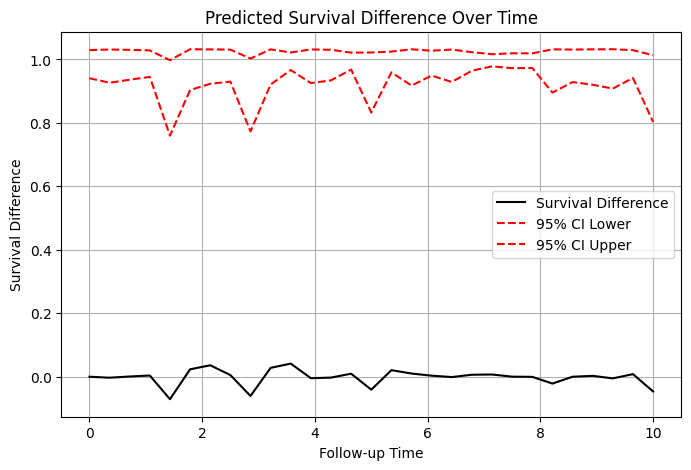

In [38]:

# Step 9: Inference (Predict Survival Probabilities)
def predict_survival(model, df):
    """Estimates survival probabilities over follow-up time."""
    df_pred = df[df["trial_period"] == 1].copy()

    if df_pred.empty:
        print("❌ No valid data for trial_period == 1!")
        return None

    df_pred["followup_time"] = np.linspace(0, 10, len(df_pred))
    df_pred["predicted_prob"] = model.predict(df_pred)
    df_pred["survival"] = 1 - df_pred["predicted_prob"]
    df_pred["survival"] = df_pred["survival"].clip(0, 1)

    pred_var = df_pred["predicted_prob"] * (1 - df_pred["predicted_prob"])
    df_pred["survival_lower"] = df_pred["survival"] - 1.96 * np.sqrt(pred_var / len(df_pred))
    df_pred["survival_upper"] = df_pred["survival"] + 1.96 * np.sqrt(pred_var / len(df_pred))

    df_pred["survival_diff"] = df_pred["survival"] - df_pred["survival"].rolling(3, min_periods=1).mean()

    return df_pred

preds_itt = predict_survival(msm_model_itt, trial_itt_sampled)

if preds_itt is None:
    print("❌ No valid survival predictions. Exiting plot.")
    exit()

# Plot survival difference over time
plt.figure(figsize=(8, 5))
plt.plot(preds_itt["followup_time"], preds_itt["survival_diff"], label="Survival Difference", color="black")

# Add 95% Confidence Intervals
plt.plot(preds_itt["followup_time"], preds_itt["survival_lower"], 'r--', label="95% CI Lower")
plt.plot(preds_itt["followup_time"], preds_itt["survival_upper"], 'r--', label="95% CI Upper")

# Labels & Legend
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Predicted Survival Difference Over Time")
plt.legend()
plt.grid(True)
plt.show()